### Import Statements

In [6]:
import osmnx as ox
import networkx as nx
import folium
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import spaghetti
import esda
import random

### Functions

In [10]:
def find_loop(start_node, G_zone):
    try:
        lengths = nx.single_source_dijkstra_path_length(G_zone, start_node, weight='length')
        far_nodes = [n for n, d in lengths.items() if 16000 < d < 26000]
        if not far_nodes:
            return None
        end_node = random.choice(far_nodes)
        path_out = nx.shortest_path(G_zone, start_node, end_node, weight='length')
        path_back = nx.shortest_path(G_zone, end_node, start_node, weight='length')
        full_path = path_out + path_back[1:]
        total_length = sum(
            G_zone[u][v][0]['length'] for u, v in zip(full_path[:-1], full_path[1:])
        )
        return (full_path, total_length)
    except:
        return None

### Task A

#### Graph Generation

In [4]:
latitude = 53.800728
longitude = -1.551573
road_network = ox.graph_from_point((latitude, longitude), dist=560, network_type='drive')

#### Normal Plotting

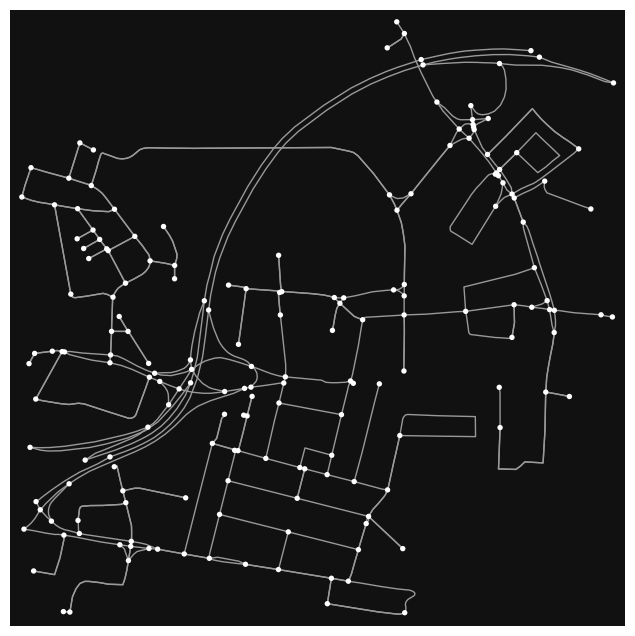

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
ox.plot_graph(road_network)

#### Folium Plotting

In [6]:
def plot_graph_folium(graph):
    nodes, edges = ox.graph_to_gdfs(graph)
    edges_union = edges.geometry.union_all()
    centroid = edges_union.centroid
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=16)
    folium.GeoJson(edges).add_to(m)
    display(m)

In [10]:
plot_graph_folium(road_network)

#### Graph Statistics

##### Covered Area

In [11]:
nodes, edges = ox.graph_to_gdfs(road_network)
edges_proj = edges.to_crs(edges.estimate_utm_crs())
buffered = edges_proj.buffer(60)
area_polygon = buffered.union_all()
area_km2 = area_polygon.area / 1e6
print("Buffered area: ", area_km2)

Buffered area:  1.0492445024562331


##### Misc. Statistics

In [46]:
graph_proj = ox.project_graph(road_network)
area_m2 = area_km2 * 1e6
stats = ox.basic_stats(graph_proj, area=area_m2)
print("Average Street Length: ", stats["street_length_avg"])
print("Node Density: ", stats["node_density_km"])
print("Edge Density: ", stats["edge_density_km"])
print("Intersection Density: ", stats["intersection_density_km"])
print("Average Circuity: ", stats["circuity_avg"])
graph_undirected = road_network.to_undirected()
G_sub = max(nx.connected_components(graph_undirected), key=len)
G_lcc = graph_undirected.subgraph(G_sub)
diameter = nx.diameter(G_lcc)
print("Network diameter:", diameter)

Average Street Length:  82.90369600851344
Node Density:  172.50507348505266
Edge Density:  25268.631278242254
Intersection Density:  146.77227246794536
Average Circuity:  1.0934746395952561
Network diameter: 22


##### Planarity

Network Planarity:  False


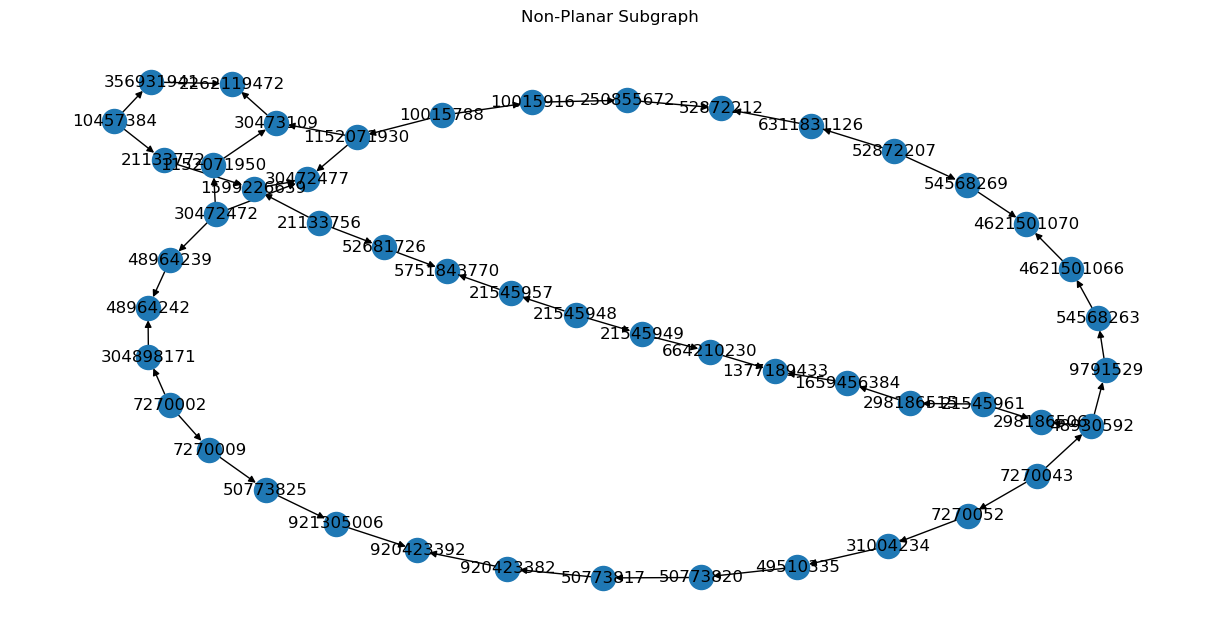

In [22]:
planar, counterexample = nx.check_planarity(road_network, counterexample=True)
print("Network Planarity: ", planar)
if not planar:
    plt.figure(figsize=(12, 6))
    nx.draw(counterexample, pos=nx.kamada_kawai_layout(counterexample), with_labels=True, arrows=True, arrowstyle='-|>')
    plt.title("Non-Planar Subgraph")
    plt.show()

### Task B

#### Dataset Addition

The dataset was in Eastings and Northings for due to UK standards. This was converted to lat/lon co-ordinates to be applied to the graph properly.

In [23]:
accident_files = [
    'dataset/2009.csv',
    'dataset/2010.csv',
    'dataset/2011.csv',
    'dataset/2012.csv',
    'dataset/2013.csv',
    'dataset/2014.csv',
    'dataset/2015.csv',
    'dataset/Leeds_RTC_2016.csv',
    'dataset/Leeds_RTC_2017.csv',
    'dataset/RTC 2018_Leeds.csv',
    'dataset/Traffic accidents_2019_Leeds.csv'
]
easting = ['Easting', 'Grid Ref: Easting', 'Easting_rounded']
northing = ['Northing', 'Grid Ref: Northing', 'Northing_rounded']
gdf_list = []

for file in accident_files:
    df = pd.read_csv(file, encoding='ISO-8859-1')
    easting_col = next((col for col in easting if col in df.columns), None)
    northing_col = next((col for col in northing if col in df.columns), None)
    if not easting_col or not northing_col:
        print("Skipping", file, ": Easting/Northing columns not found.")
        continue
    df = df.dropna(subset=[easting_col, northing_col])
    geometry = [Point(xy) for xy in zip(df[easting_col], df[northing_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:27700")
    gdf = gdf.to_crs(epsg=4326)
    gdf_list.append(gdf)

all_accidents = pd.concat(gdf_list, ignore_index=True)
all_accidents = all_accidents.drop_duplicates(subset='geometry')
print("Total accident records: ", len(all_accidents))

Total accident records:  19629


#### Snapping Accident Points to Network

In [26]:
spaghetti_net = spaghetti.Network(in_data=edges)
network_area = edges.union_all().convex_hull
accidents_in_area = all_accidents[all_accidents.geometry.within(network_area)]
spaghetti_net.snapobservations(accidents_in_area, 'accidents')

c:\Users\alikh\.conda\envs\nda\lib\site-packages\libpysal\cg\shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
c:\Users\alikh\.conda\envs\nda\lib\site-packages\libpysal\cg\shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
c:\Users\alikh\.conda\envs\nda\lib\site-packages\libpysal\cg\shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


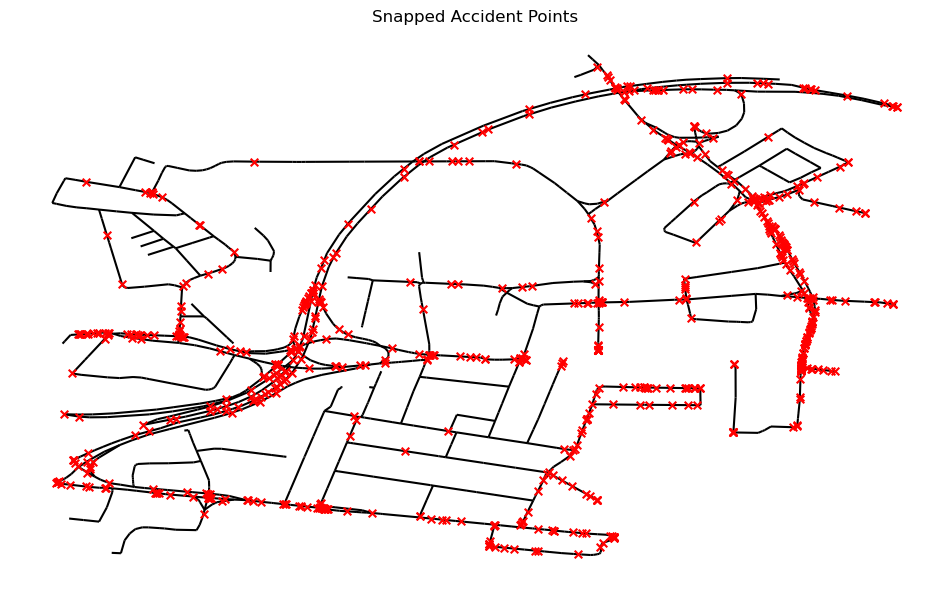

In [35]:
nodes_gdf, edges_gdf = spaghetti.element_as_gdf(spaghetti_net, vertices=True, arcs=True)
snapped_accidents_gdf = spaghetti.element_as_gdf(spaghetti_net, pp_name='accidents', snapped=True)
base = edges_gdf.plot(color="black", figsize=(12, 12), zorder=0)
snapped_accidents_gdf.plot(ax=base, color="red", marker="x", markersize=30, zorder=1)
plt.title("Snapped Accident Points")
plt.axis("off")
plt.show()

##### Number of Accidents Snapped

In [36]:
num_accidents = len(spaghetti_net.pointpatterns["accidents"].points)
print("Number of accidents snapped: ", num_accidents)

Number of accidents snapped:  698


#### K Function

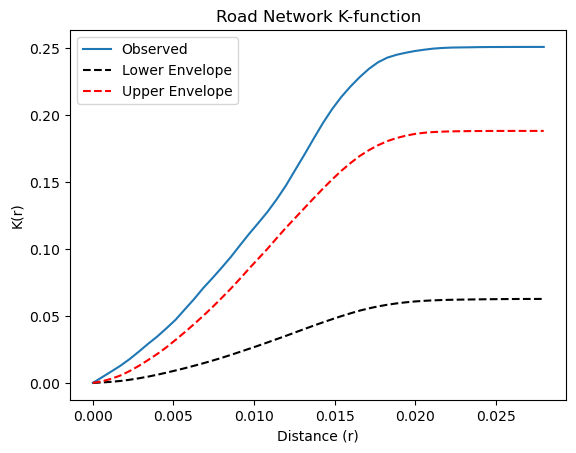

In [38]:
kres = spaghetti_net.GlobalAutoK(spaghetti_net.pointpatterns["accidents"], nsteps=50, permutations=100)
plt.plot(kres.xaxis, kres.observed, label='Observed')
plt.plot(kres.xaxis, kres.lowerenvelope, 'k--', label='Lower Envelope')
plt.plot(kres.xaxis, kres.upperenvelope, 'r--', label='Upper Envelope')
plt.xlabel('Distance (r)')
plt.ylabel('K(r)')
plt.legend()
plt.title("Road Network K-function")
plt.show()

#### Moran's I

In [ ]:
pointpat = spaghetti_net.pointpatterns["accidents"]
counts = spaghetti_net.count_per_link(pointpat.obs_to_arc, graph=False)
weights = spaghetti_net.w_network
edges = weights.neighbors.keys()
values = [counts.get(edge, 0.0) for edge in edges]
moran = esda.moran.Moran(values, weights)
print("P-value: ", moran.p_sim)
expected_I = -1 / (len(values) - 1)
print("Actual Moran's I: ", moran.I)
print("Expected Moran's I: ", expected_I)

P-value:  0.001
Actual Moran's I:  0.24360955254198016
Expected Moran's I:  -0.0008375209380234506


#### Accident Distribution

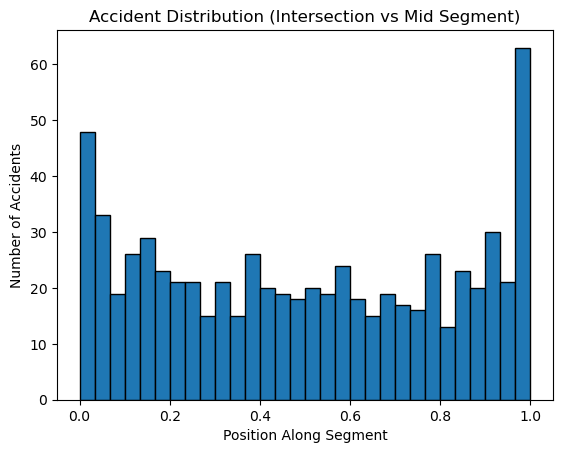

In [42]:
snapped_accidents = pointpat.obs_to_arc
accident_fractions = {}
for arc, observations in snapped_accidents.items():
    for obs_id, snapped_coords in observations.items():
        x, y = snapped_coords
        d1, d2 = spaghetti_net.compute_distance_to_vertices(x, y, arc)
        total_length = d1 + d2
        fraction_along_segment = d1 / total_length
        accident_fractions[obs_id] = fraction_along_segment

fractions = list(accident_fractions.values())
plt.hist(fractions, bins=30, edgecolor='black')
plt.xlabel('Position Along Segment')
plt.ylabel('Number of Accidents')
plt.title('Accident Distribution (Intersection vs Mid Segment)')
plt.show()

### Task C

#### Graph Generation

In [11]:
place = "Leeds, United Kingdom"
G = ox.graph_from_place(place, network_type="all")
manual_seeds = [(53.813642, -1.538839), (53.805439, -1.636859), (53.833180, -1.538746), (53.803829, -1.452389) ]
seed_nodes = [ox.distance.nearest_nodes(G, X=lon, Y=lat) for lat, lon in manual_seeds]
voronoi = nx.voronoi_cells(G, seed_nodes, weight='length')
variation = 500

#### Voronoi Path Finding

##### Seed 1

In [12]:
seed = seed_nodes[0]
zone1_nodes = voronoi[seed]
G_zone1 = G.subgraph(zone1_nodes)

In [ ]:
best_path = None
best_dist = float('inf')
found_paths = []

trial_nodes = random.choices(list(G_zone1.nodes), k=1000)
for node in trial_nodes:
    result = find_loop(node, G_zone1)
    if result:
        path, dist = result
        if abs(dist - 42000) <= variation:
            found_paths.append((path, dist))
            if abs(dist - 42000) < abs(best_dist - 42000):
                best_path = path
                best_dist = dist
            if(len(found_paths)==3):
                break

print(len(found_paths), "valid paths found!")

0 valid paths found!


Plotting

In [14]:
best_candidates = sorted(found_paths, key=lambda x: abs(x[1] - 42000))
for i, (path, dist) in enumerate(best_candidates):
    print("Path nodes: ", path)
    print("Path length: ", dist/1000)
    ox.plot_graph_route(G_zone1, path, route_color='yellow', bgcolor='k', node_size=0, edge_linewidth=0.5, save=True, filepath=f'/Voronoi/zone1_loop{i+1}.png')

##### Seed 2

In [15]:
seed = seed_nodes[1]
zone2_nodes = voronoi[seed]
G_zone2 = G.subgraph(zone2_nodes)

In [ ]:
best_path = None
best_dist = float('inf')
found_paths = []

trial_nodes = random.choices(list(G_zone2.nodes), k=1000)
for node in trial_nodes:
    result = find_loop(node, G_zone2)
    if result:
        path, dist = result
        if abs(dist - 42000) <= variation:
            found_paths.append((path, dist))
            if abs(dist - 42000) < abs(best_dist - 42000):
                best_path = path
                best_dist = dist
            if(len(found_paths)==3):
                break

print(len(found_paths), "valid paths found!")

3 valid paths found!


Plotting

Path length:  42035.792972070245


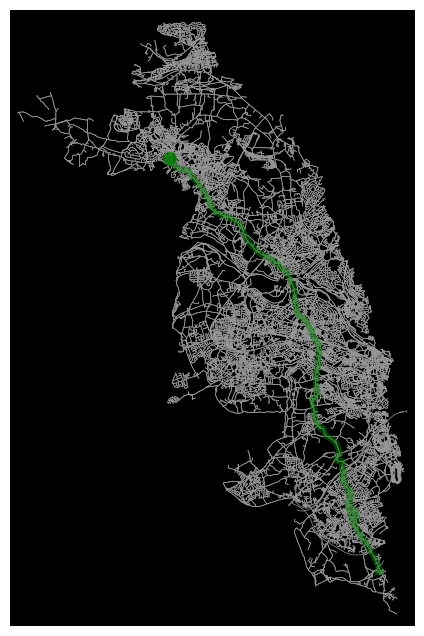

Path length:  42082.1897576173


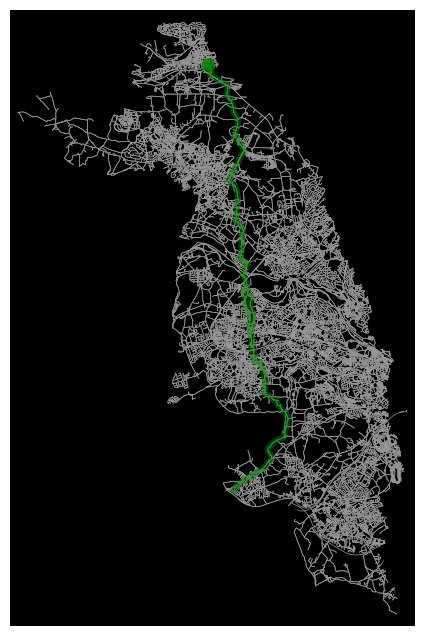

Path length:  41722.88982519098


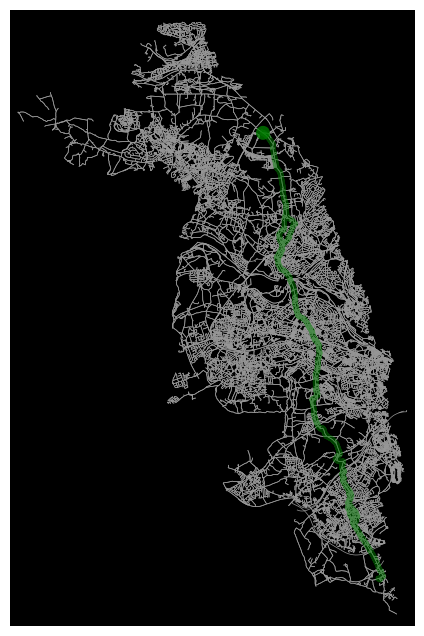

In [19]:
best_candidates = sorted(found_paths, key=lambda x: abs(x[1] - 42000))
for i, (path, dist) in enumerate(best_candidates):
    print("Path length: ", dist)
    ox.plot_graph_route(G_zone2, path, route_color='green', bgcolor='k', node_size=0, edge_linewidth=0.5, save=True, filepath=f'/Voronoi/zone2_loop{i+1}.png')

##### Seed 3

In [20]:
seed = seed_nodes[2]
zone3_nodes = voronoi[seed]
G_zone3 = G.subgraph(zone3_nodes)

In [ ]:
best_path = None
best_dist = float('inf')
found_paths = []

trial_nodes = random.choices(list(G_zone3.nodes), k=1000)
for node in trial_nodes:
    result = find_loop(node, G_zone3)
    if result:
        path, dist = result
        if abs(dist - 42000) <= variation:
            found_paths.append((path, dist))
            if abs(dist - 42000) < abs(best_dist - 42000):
                best_path = path
                best_dist = dist
            if(len(found_paths)==3):
                break

print(len(found_paths), "valid paths found!")

3 valid paths found!


Plotting

Path length:  41736.08125847571


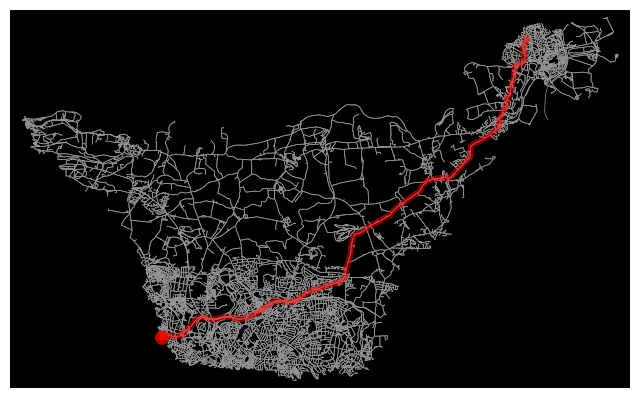

Path length:  41682.55551357206


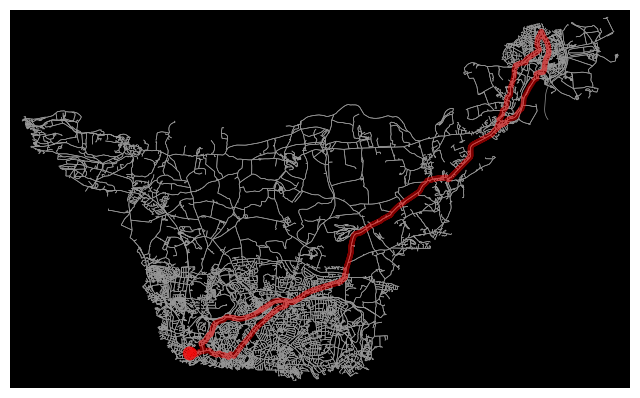

Path length:  41582.07745750988


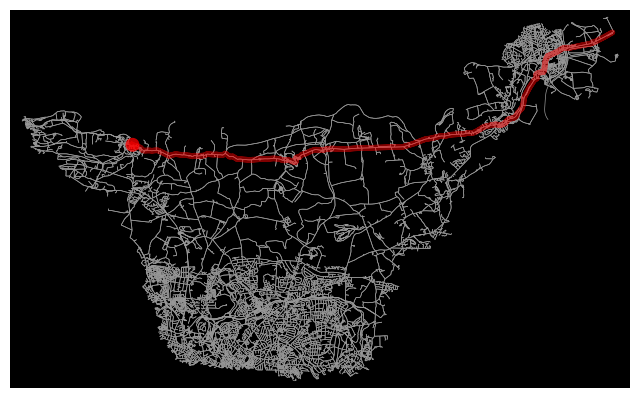

In [26]:
best_candidates = sorted(found_paths, key=lambda x: abs(x[1] - 42000))
for i, (path, dist) in enumerate(best_candidates):
    print("Path length: ", dist)
    ox.plot_graph_route(G_zone3, path, route_color='red', bgcolor='k', node_size=0, edge_linewidth=0.5, save=True, filepath=f'/Voronoi/zone3_loop{i+1}.png')

##### Seed 4

In [27]:
seed = seed_nodes[3]
zone4_nodes = voronoi[seed]
G_zone4 = G.subgraph(zone4_nodes)

In [28]:
best_path = None
best_dist = float('inf')
found_paths = []

trial_nodes = random.choices(list(G_zone4.nodes), k=1000)
for node in trial_nodes:
    result = find_loop(node, G_zone4)
    if result:
        path, dist = result
        if abs(dist - 42000) <= variation:
            found_paths.append((path, dist))
            if abs(dist - 42000) < abs(best_dist - 42000):
                best_path = path
                best_dist = dist
            if(len(found_paths)==3):
                break

print(len(found_paths), "valid paths found!")

3 valid paths found!


Plotting

Path length:  42050.88284009742


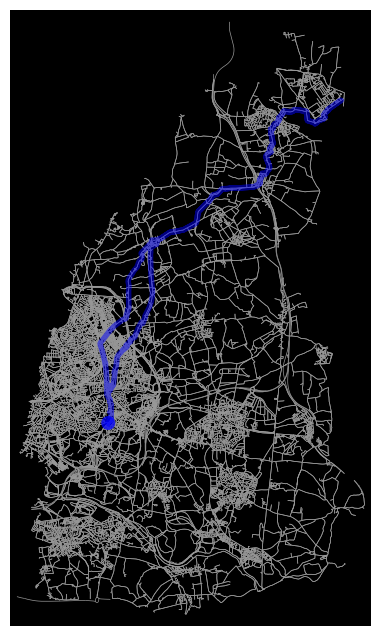

Path length:  42390.90613609978


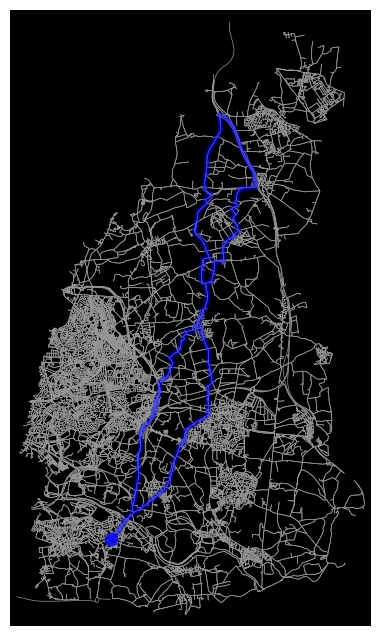

Path length:  41596.58521614421


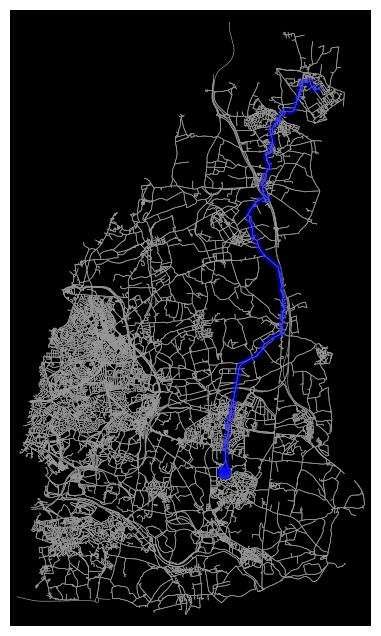

In [29]:
best_candidates = sorted(found_paths, key=lambda x: abs(x[1] - 42000))
for i, (path, dist) in enumerate(best_candidates):
    print("Path length: ", dist)
    ox.plot_graph_route(G_zone4, path, route_color='blue', bgcolor='k', node_size=0, edge_linewidth=0.5, save=True, filepath=f'/Voronoi/zone4_loop{i+1}.png')